In [4]:
# TensorFlow 2.0.0 is required for this code to work.
# Uncomment and run the following line to install the CPU version.
# !pip install tensorflow==2.0.0-beta0 --ignore-installed

### Import necessary modules:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import shuffle
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from functools import reduce
import os
import json
from PIL import Image

### Get a list of all hashtags

In [6]:
json_file_names = os.listdir('json_files')
# Remove the 5 char .json file ending to isolate hashtag name
hashtags = [hashtag[:-5] for hashtag in json_file_names]

In [7]:
# remove '.DS_', '.ipynb_checkp'
hashtags.remove('.DS_')
hashtags.remove('.ipynb_checkp')
hashtags

['fitness',
 'selfie',
 'travel',
 'nature',
 'babies',
 'cars',
 'food',
 'architecture',
 'animals',
 'wedding']

In [8]:
hashtag_dfs = []
for hashtag in hashtags: 
    hashtag_dfs.append(pd.read_json(f'json_files/{hashtag}.json'))
df = reduce(lambda x, y: pd.concat([x, y]), hashtag_dfs)

In [9]:
full_list = pd.DataFrame.reset_index(df, drop=True)

In [10]:
full_list.tail()

,hashtags,image,image_local_name,post_link,search_hashtag
2995,"[#Wedding, #ido, #ianandwendytietheknot, #wedd...",https://scontent-sea1-1.cdninstagram.com/vp/29...,905a1d9c-b29d-44c7-ab5c-408c0b5d91ac.jpg,https://www.instagram.com/p/B0dcq0FBPQ3/,wedding
2996,"[#wedding, #mariages, #celebrantecuritiba, #ce...",https://scontent-sea1-1.cdninstagram.com/vp/bb...,6e424f02-d10e-42db-a233-9ce2724fb8a9.jpg,https://www.instagram.com/p/BwXbu7MgCTZ/,wedding
2997,"[#weddingring, #wedding, #shoes, #nancy, #sigm...",https://scontent-sea1-1.cdninstagram.com/vp/25...,ae49d2bb-95f7-4d16-9ee5-1603e97e6dd8.jpg,https://www.instagram.com/p/B0gwuc2icKv/,wedding
2998,"[#wedding, #standesamtgoetheallee, #retroweddi...",https://scontent-sea1-1.cdninstagram.com/vp/21...,9152a6d4-abda-4adf-87a4-7988dc4bb3ac.jpg,https://www.instagram.com/p/B0gwufzImAz/,wedding
2999,"[#kinalik, #gelinlik, #bursad, #wedding, #dama...",https://scontent-sea1-1.cdninstagram.com/vp/15...,09aaa471-2ed6-4ead-84db-e4aa6b0ece8f.jpg,https://www.instagram.com/p/B0gwubDhu6M/,wedding


### Resizing image to be used in tensorflow framework for Deep Feature Extraction

In [11]:
img_size = 160 # All images will be resized to 160x160
img_shape = (160, 160, 3)

def prepare_image(img_path, height=img_size, width=img_size):
    """Downsample and scale image to prepare it for neural network"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (height, width))
    # Reshape B&W images to match dimensions of color images
    if img.shape != (160, 160, 3):
        img = tf.concat([img, img, img], axis=2)
    return img

In [12]:
pics = []
for i, row in full_list.iterrows():
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path)
        pics.append({'pic': img, 'hashtag': hashtag, 'name': name})
    except:
        # If a file in the list isn't in 
        # storage, skip it and continue
        pass

In [13]:
type(pics[64]['pic'])

tensorflow.python.framework.ops.EagerTensor

W0809 09:48:06.117023 4348450240 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


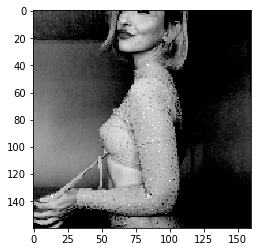

In [14]:
plt.imshow(pics[64]['pic']);

In [15]:
# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

neural_network = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

In [16]:
def extract_features(image_dict):
    """Return a vector of 1280 deep features for image."""
    image = image_dict['pic']
    image_np = image.numpy()
    images_np = np.expand_dims(image_np, axis=0)
    image_np.shape, images_np.shape
    deep_features = neural_network.predict(images_np)
    image_dict['deep_features'] = deep_features[0]
    return image_dict

In [17]:
deep_features = list(map(extract_features, pics))

In [18]:
type(deep_features)

list

In [19]:
shuffle(deep_features)
train_size = int(len(deep_features) * .7)
train, test = deep_features[:train_size], deep_features[train_size:]

In [20]:
train[0]

{'pic': <tf.Tensor: id=70796, shape=(160, 160, 3), dtype=float32, numpy=
 array([[[ 0.9605086 ,  0.9683517 ,  0.99972427],
         [ 0.94509804,  0.9529412 ,  0.9843137 ],
         [ 0.9262255 ,  0.9340686 ,  0.96544117],
         ...,
         [ 0.78710175,  0.78710175,  0.8488052 ],
         [ 0.7175858 ,  0.76709557,  0.79503673],
         [ 0.7754289 ,  0.8514706 ,  0.8619792 ]],
 
        [[ 0.952114  ,  0.9599571 ,  0.99132967],
         [ 0.9387561 ,  0.94659925,  0.9779718 ],
         [ 0.9459559 ,  0.953799  ,  0.98517156],
         ...,
         [-0.3496936 , -0.35732228, -0.29457718],
         [ 0.72107846,  0.7598346 ,  0.7921875 ],
         [ 0.5631434 ,  0.62588847,  0.64304537]],
 
        [[ 0.9795649 ,  0.98740804,  0.9948836 ],
         [ 0.90067405,  0.9085172 ,  0.9398897 ],
         [ 0.9891544 ,  0.99699754,  0.9994179 ],
         ...,
         [-0.705239  , -0.72778803, -0.65769   ],
         [ 0.7101716 ,  0.74056375,  0.77634805],
         [ 0.65404415,  0.694

In [21]:
train[0].keys()

dict_keys(['pic', 'hashtag', 'name', 'deep_features'])

In [22]:
pic = train[0]

W0809 09:51:34.382545 4348450240 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


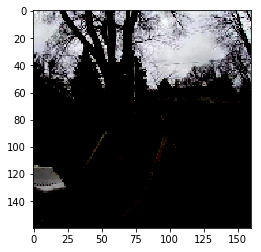

In [23]:
plt.imshow(pic['pic']);

In [24]:
pic['hashtag']

'animals'

In [25]:
pic['deep_features'].shape

(1280,)

In [26]:
pic['pic'].shape

TensorShape([160, 160, 3])

In [27]:
df = pd.DataFrame(deep_features)

In [28]:
df.head()

,deep_features,hashtag,name,pic
0,"[0.20390263, 0.35791588, 0.0, 0.11959089, 0.00...",animals,ff25ba01-800e-4e46-99bd-062fff5b0ee8.jpg,"(((tf.Tensor(0.9605086, shape=(), dtype=float3..."
1,"[1.9869195, 0.053759612, 0.0, 0.0658462, 0.0, ...",architecture,1dd5f33d-86d5-46db-876c-776cd2bcc29e.jpg,"(((tf.Tensor(0.6745098, shape=(), dtype=float3..."
2,"[0.0, 0.0, 0.047620296, 0.0, 0.043269824, 0.13...",travel,6fe315be-a598-4a87-aefb-835b07e55676.jpg,"(((tf.Tensor(-0.7254902, shape=(), dtype=float..."
3,"[0.0, 0.0, 1.8810314, 0.052851543, 0.0, 3.6374...",cars,a3384a2d-1d24-4108-8f25-cde7ed68f7df.jpg,"(((tf.Tensor(-0.7490196, shape=(), dtype=float..."
4,"[0.047524728, 0.0241852, 0.13619101, 0.5469168...",nature,852ef348-da2d-4273-9bba-4dbd65b8b327.jpg,"(((tf.Tensor(0.13333338, shape=(), dtype=float..."


In [29]:
df.to_pickle("pkl_files/df_deep_features.pkl")

## ALS Model

In [30]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel

In [31]:
spark = SparkSession.builder.master('local').getOrCreate()

In [32]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(full_list, test_size=0.2)

In [33]:
train.head()

,hashtags,image,image_local_name,post_link,search_hashtag
521,"[#motivation, #beards, #model, #fitness, #guys...",https://scontent-sea1-1.cdninstagram.com/vp/ef...,23909209-2169-4395-9af3-5e474f085e39.jpg,https://www.instagram.com/p/BouLgokhD-k/,selfie
53,"[#gym, #love, #instagood, #bestoftheday, #foll...",https://scontent-mad1-1.cdninstagram.com/vp/c7...,0dcd6865-c63f-4060-8942-8747a6c14847.jpg,https://www.instagram.com/p/B021HEjF877/,fitness
542,"[#daily, #ootd, #selfie, #dm, #f, #fff]",https://scontent-sea1-1.cdninstagram.com/vp/50...,b60247f2-8ca8-46e0-8638-aa262975bb59.jpg,https://www.instagram.com/p/B0g-1x2FNB4/,selfie
1126,"[#lappland, #skog, #lifeinswedishlapland, #nik...",https://scontent-mad1-1.cdninstagram.com/vp/6b...,1d2be177-bdb4-42a7-8034-8d91d1f66d6f.jpg,https://www.instagram.com/p/B07rsU6gVpz/,nature
639,"[#menstyletrend, #mensluggage, #visitgreenvill...",https://scontent-lga3-1.cdninstagram.com/vp/22...,85b81a9c-25bb-4a83-80ea-9daf83a078ea.jpg,https://www.instagram.com/p/By3OIAJnk_e/,travel


In [34]:
len(train)

2400

In [35]:
#full_list.head()

In [36]:
full_list['clean_hashtags'] = full_list['hashtags'].apply(
    lambda hashtag_list: [h for h in hashtag_list if h.startswith('#')])

In [37]:
image_lookup = dict(zip(full_list['image_local_name'], full_list.index))

In [38]:
all_hashtags = set()
for tags in full_list['clean_hashtags']:
    all_hashtags.update(tags)
hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [39]:
hashtag_data = []
for i in full_list.index:
    hashtags = full_list.loc[i, 'clean_hashtags']
    for hashtag in hashtags:
        hashtag_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_df_long = pd.DataFrame(hashtag_data)

In [40]:
hashtag_df_long.tail()

,hashtag_id,image_id,rating
47467,11177,2999,1
47468,2708,2999,1
47469,2709,2999,1
47470,11814,2999,1
47471,1002,2999,1


In [41]:
full_list.dtypes

hashtags            object
image               object
image_local_name    object
post_link           object
search_hashtag      object
clean_hashtags      object
dtype: object

In [42]:
als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

In [43]:
hashtag_spark_df = spark.createDataFrame(hashtag_df_long)

In [44]:
als_model = als.fit(hashtag_spark_df)

In [46]:
als_model.save('als')

In [47]:
#load the model
#ALSModel model = ALSModel.load(“/path/to/read/the/model/from”)

In [48]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()

In [49]:
len(recs)

2261

In [50]:
hashtag_index = list(all_hashtags)

In [51]:
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

In [52]:
def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [53]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)

In [54]:
recs.index = recs['image_id']

In [55]:
compare_recs = recs.join(full_list, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [56]:
compare_recs.loc[0, 'image_local_name']

'ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg'

In [57]:
compare_recs.to_pickle('pkl_files/recs.pkl')

In [58]:
compare_recs.drop('recommendations', axis=1)

,recommended_hashtags,hashtags,image_local_name,search_hashtag
image_id,,,,
1580,"[#luxury, #cars, #car, #lifestyle, #race, #aut...","[#checkeredflag, #atv, #flagmanracing, #dirtbi...",88039d35-d189-4db3-926e-a120d88a3efc.jpg,cars
471,"[#photo, #me, #ootd, #selfie, #daily, #like, #...","[#followme, #fashiondaily, #summer, #food, #ma...",fdc6c8d4-5a13-4330-9098-07e09e4858d2.jpg,selfie
1591,"[#cars, #car, #luxury, #carsofinstagram, #carl...","[#bidlemanchevrolet, #suvs, #cars, #cardeals, ...",1b7a8fbc-1797-4418-b8b2-c65500e2bc6f.jpg,cars
463,"[#selfie, #daily, #food, #ootd, #like, #follow...","[#followme, #hotguy, #instaboy, #gay, #instaga...",a78d0e30-6afa-436a-a953-633ef3f64325.jpg,selfie
833,"[#nature, #art, #love, #photography, #architec...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel
1645,"[#cars, #car, #luxury, #photo, #fiat, #fiatsor...","[#cl, #fiat, #sangreitaliana, #mi, #sorpasso, ...",1b2b963b-6c4d-4c79-b88d-b04f34104a1c.jpg,cars
496,"[#selfie, #food, #like, #f, #follow, #l, #foll...","[#fashion, #oufit, #likeforlike, #selfie, #l, #f]",97f23d6a-0895-4e47-99de-af849207d71b.jpg,selfie
2866,"[#makeup, #wedding, #photoshoot, #artist, #hai...","[#teethwhitening, #temecula, #nailtech, #naili...",aad5291e-ed07-4a9a-8525-d8b1fe1bb493.jpg,wedding
148,"[#food, #fitness, #foodie, #instafood, #foodpo...","[#pyszne, #dietetyczny, #motywacja, #healthyfo...",79b4e782-1b3f-4ecd-b0d3-9ea54cf4d037.jpg,fitness


In [59]:
image_factors = als_model.userFactors.toPandas()

In [60]:
image_factors.index = image_factors['id']

In [61]:
compare_recs.join(image_factors)

,recommendations,recommended_hashtags,hashtags,image_local_name,search_hashtag,id,features
image_id,,,,,,,
1580,"[(10406, 1.146733283996582), (6872, 1.06506204...","[#luxury, #cars, #car, #lifestyle, #race, #aut...","[#checkeredflag, #atv, #flagmanracing, #dirtbi...",88039d35-d189-4db3-926e-a120d88a3efc.jpg,cars,1580,"[-0.39753857254981995, 0.03570248559117317, -0..."
471,"[(12028, 1.152119755744934), (13442, 1.1455943...","[#photo, #me, #ootd, #selfie, #daily, #like, #...","[#followme, #fashiondaily, #summer, #food, #ma...",fdc6c8d4-5a13-4330-9098-07e09e4858d2.jpg,selfie,471,"[-0.6170209646224976, -0.6904682517051697, 0.3..."
1591,"[(6872, 0.9910037517547607), (12076, 0.7656257...","[#cars, #car, #luxury, #carsofinstagram, #carl...","[#bidlemanchevrolet, #suvs, #cars, #cardeals, ...",1b7a8fbc-1797-4418-b8b2-c65500e2bc6f.jpg,cars,1591,"[0.010120289400219917, -0.14125625789165497, 0..."
463,"[(5798, 0.8138610124588013), (5481, 0.74504423...","[#selfie, #daily, #food, #ootd, #like, #follow...","[#followme, #hotguy, #instaboy, #gay, #instaga...",a78d0e30-6afa-436a-a953-633ef3f64325.jpg,selfie,463,"[-0.21066850423812866, -0.1887151151895523, 0...."
833,"[(7160, 1.0691499710083008), (6119, 0.91959476...","[#nature, #art, #love, #photography, #architec...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel,833,"[-0.3970666527748108, 0.7391157150268555, -0.3..."
1645,"[(6872, 0.9361506104469299), (12076, 0.9004099...","[#cars, #car, #luxury, #photo, #fiat, #fiatsor...","[#cl, #fiat, #sangreitaliana, #mi, #sorpasso, ...",1b2b963b-6c4d-4c79-b88d-b04f34104a1c.jpg,cars,1645,"[-0.6532610058784485, -0.7852634191513062, 0.3..."
496,"[(5798, 0.8913271427154541), (524, 0.737780034...","[#selfie, #food, #like, #f, #follow, #l, #foll...","[#fashion, #oufit, #likeforlike, #selfie, #l, #f]",97f23d6a-0895-4e47-99de-af849207d71b.jpg,selfie,496,"[-0.25273597240448, -0.31100234389305115, 0.08..."
2866,"[(7307, 0.9486185312271118), (1047, 0.90157520...","[#makeup, #wedding, #photoshoot, #artist, #hai...","[#teethwhitening, #temecula, #nailtech, #naili...",aad5291e-ed07-4a9a-8525-d8b1fe1bb493.jpg,wedding,2866,"[-0.5766879916191101, 0.6691043376922607, 0.16..."
148,"[(524, 1.0449734926223755), (2400, 0.866305112...","[#food, #fitness, #foodie, #instafood, #foodpo...","[#pyszne, #dietetyczny, #motywacja, #healthyfo...",79b4e782-1b3f-4ecd-b0d3-9ea54cf4d037.jpg,fitness,148,"[-0.17287704348564148, 0.0626547634601593, -0...."


### Pickle hashtag data

In [62]:
hashtag_lookup

{'#instahub': 0,
 '#thejourney': 1,
 '#mfw': 2,
 '#alpacalover': 3,
 '#pilatesstudio': 4,
 '#belajarmotret': 5,
 '#gezgin': 6,
 '#manhattan': 7,
 '#dashboard': 8,
 '#lovequote': 9,
 '#nomakeup': 10,
 '#lucasblack': 11,
 '#Datsun': 12,
 '#petsofinsta': 13,
 '#bestmen': 14,
 '#comedy': 15,
 '#cannabiscures': 16,
 '#onlyme': 17,
 '#westlouisville': 18,
 '#shorthair': 19,
 '#gonnamisscolorado': 20,
 '#dessinateur': 21,
 '#mexico': 22,
 '#slub': 23,
 '#Ladies': 24,
 '#moutains': 25,
 '#New': 26,
 '#russian': 27,
 '#LoHizoRicoPopayan': 28,
 '#antiaging': 29,
 '#ekgida': 30,
 '#historic': 31,
 '#sedancar': 32,
 '#igmuscle': 33,
 '#orangecountry': 34,
 '#weddingbackdrop': 35,
 '#instatravel': 36,
 '#shimano': 37,
 '#barbeariavipingleses': 38,
 '#games': 39,
 '#lasanha': 40,
 '#leo': 41,
 '#recentforrecent': 42,
 '#wasserfall': 43,
 '#mustangs': 44,
 '#Home': 45,
 '#stage': 46,
 '#mittelmeer': 47,
 '#vscomag': 48,
 '#secondwedding': 49,
 '#fatloss': 50,
 '#active': 51,
 '#physiotherapie': 52,
 

In [63]:
hashtags_df = pd.DataFrame.from_dict(hashtag_lookup, orient='index')
hashtags_df.head()

,0
#instahub,0
#thejourney,1
#mfw,2
#alpacalover,3
#pilatesstudio,4


In [64]:
hashtags_df = hashtags_df.reset_index()
hashtags_df.columns = ['hashtag', 'id']

In [65]:
hashtags_df.index = hashtags_df['id']

In [66]:
hashtags_df = hashtags_df.drop('id', axis=1)

In [67]:
hashtags_df.head()

,hashtag
id,
0,#instahub
1,#thejourney
2,#mfw
3,#alpacalover
4,#pilatesstudio


In [68]:
hashtags_df.to_pickle("pkl_files/hashtags_df.pkl")